In [1]:
import pandas as pd
pca_rowwise_df = pd.read_csv("data/pca_rowwise.csv")
pca_rowwise_df['layer_change'] = (pca_rowwise_df['layer_id'].diff() != 0).astype(int)
pca_rowwise_df['t'] = pca_rowwise_df.index
# Convert 'layer_id' to categorical and create 25 boolean variables
layer_id_dummies = pd.get_dummies(pca_rowwise_df['layer_id'], prefix='layer_id')
pca_rowwise_df = pd.concat([pca_rowwise_df, layer_id_dummies], axis=1)
pca_rowwise_df.head()

,T2,layer_id,layer_change,t,layer_id_0,layer_id_1,layer_id_2,layer_id_3,layer_id_4,layer_id_5,...,layer_id_15,layer_id_16,layer_id_17,layer_id_18,layer_id_19,layer_id_20,layer_id_21,layer_id_22,layer_id_23,layer_id_24
0,18.847691,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.979106,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15.267905,0,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12.919741,0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15.405597,0,0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


                            OLS Regression Results                            
Dep. Variable:                     T2   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     208.1
Date:                ven, 09 mag 2025   Prob (F-statistic):               0.00
Time:                        14:11:50   Log-Likelihood:                -11954.
No. Observations:                3000   AIC:                         2.396e+04
Df Residuals:                    2973   BIC:                         2.412e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           24.1686     10.062      2.402   

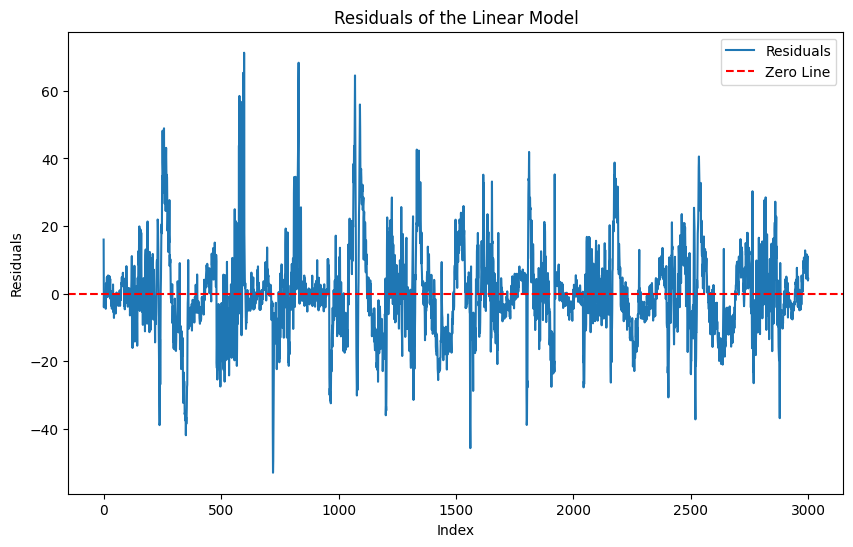

In [2]:
import statsmodels.api as sm

# Select covariates excluding 'layer_id'
covariates = pca_rowwise_df.drop(columns=['T2', 'layer_id'])

# Add a constant for the intercept
covariates = sm.add_constant(covariates)

# Fit the linear model
model = sm.OLS(pca_rowwise_df['T2'], covariates).fit()

# Print the summary of the model
print(model.summary())

import matplotlib.pyplot as plt

# Calculate residuals
residuals = model.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of the Linear Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.legend()
plt.show()

14:02:15 - cmdstanpy - INFO - Chain [1] start processing
14:02:15 - cmdstanpy - INFO - Chain [1] done processing


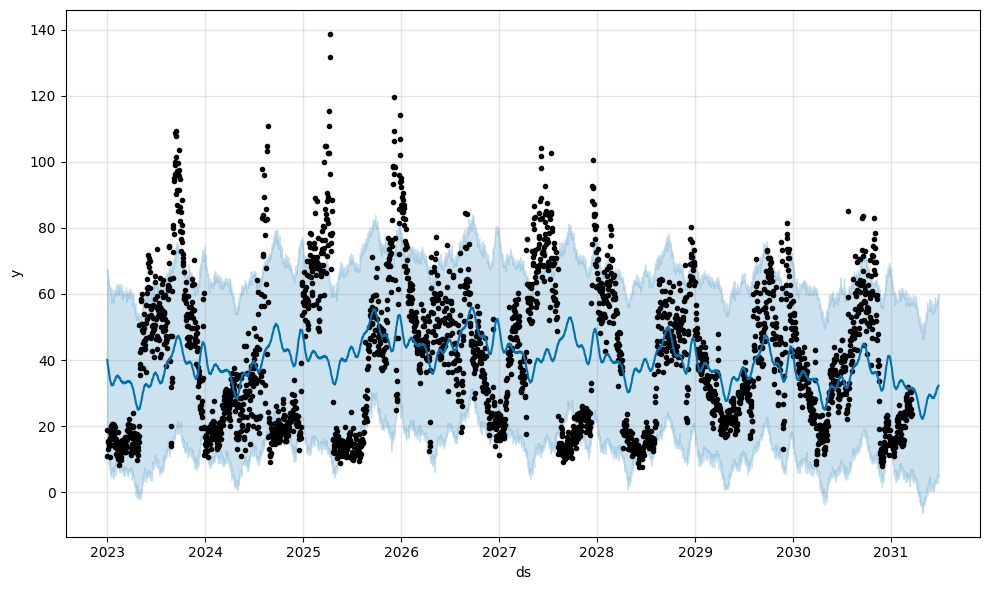

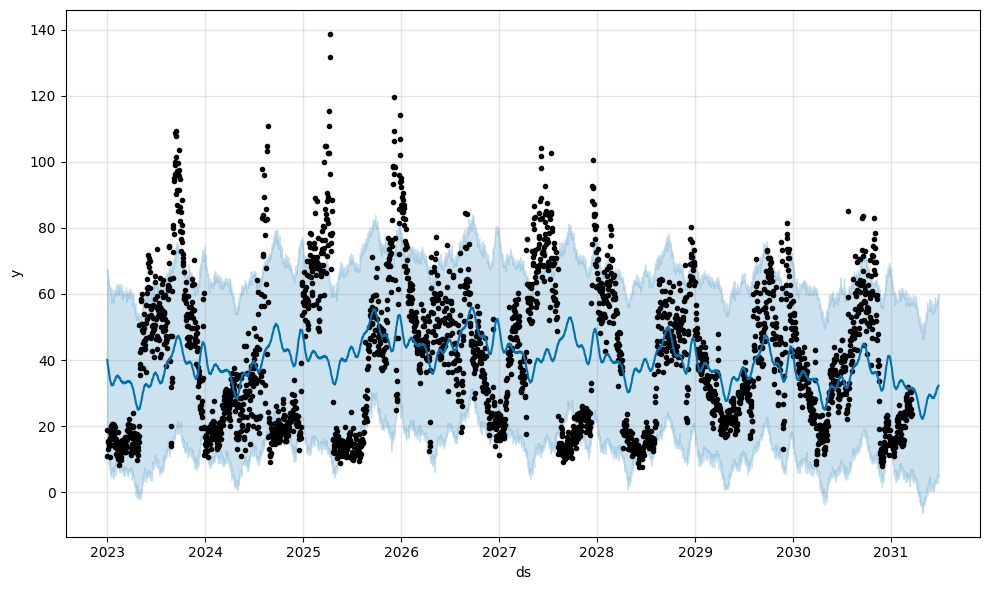

In [9]:
# Install the prophet package
#%pip install prophet

from prophet import Prophet

# Prepare the data for Prophet
# Convert 't' to datetime format starting from a specific date
prophet_df = pca_rowwise_df[['t', 'T2']].rename(columns={'t': 'ds', 'T2': 'y'})
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], origin='2023-01-01', unit='D')



# Set changepoints where 'layer_change' is 1
changepoints = prophet_df[prophet_df['ds'].isin(pca_rowwise_df[pca_rowwise_df['layer_change'] == 1]['t'].apply(lambda x: pd.Timestamp('2023-01-01') + pd.to_timedelta(x, unit='D')))]
model = Prophet(changepoints=changepoints['ds'].tolist())
model.fit(prophet_df)
# Create a dataframe for future predictions
future = model.make_future_dataframe(periods=100)  # Extend the time series by 100 steps
forecast = model.predict(future)
# Plot the forecast
model.plot(forecast)